<a href="https://colab.research.google.com/github/AbshkPskr/Covid-19-Analysis/blob/master/COVID_19_INDIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analysis of COVID-19 pandemic

##What is Corona Virus(COVID-19)?

Coronavirus is a family of viruses that can cause illness, which can vary from common cold and cough to sometimes more severe disease. SARS-CoV-2 (n-coronavirus) is the new virus of the coronavirus family, which first discovered in 2019, which has not been identified in humans before. It is a contiguous virus which started from Wuhan in December 2019. Which later declared as Pandemic by WHO due to high rate spreads throughout the world. Currently (on date 27 March 2020), this leads to a total of 24K+ Deaths across the globe, including 16K+ deaths alone in Europe.Pandemic is spreading all over the world; it becomes more important to understand about this spread. This NoteBook is an effort to analyze the cumulative data of confirmed, deaths, and recovered cases over time. In this notebook, the main focus is to analyze the spread trend of this virus all over the india.

##History of COVID-19 in India
On January 30, India reported its first case of COVID-19 in Kerala, which rose to three cases by February 3; all were students who had returned from Wuhan, China.No significant rise in cases was seen in the rest of February.

On 22 March 2020, India observed a 14-hour voluntary public curfew at the instance of the prime minister Narendra Modi.The government followed it up with lockdowns in 75 districts where COVID cases had occurred as well as all major cities.Further, on 24 March, the prime minister ordered a nationwide lockdown for 21 days, affecting the entire 1.3 billion population of India.

The transmission escalated during March, after several cases were reported all over the country, most of which were linked to people with a travel history to affected countries. On 12 March, a 76-year-old man who had returned from Saudi Arabia became the first victim of the virus in the country.On 4 March, 22 new cases came to light, including those of an Italian tourist group with 14 infected members.But number of cases start increasing dramtically after 19th March, but in the month of April it has been its peak.

Experts suggest the number of infections could be much higher as India's testing rates are among the lowest in the world.The infection rate of COVID-19 in India is reported to be 1.7, significantly lower than in the worst affected countries.

Source: Wikipedia



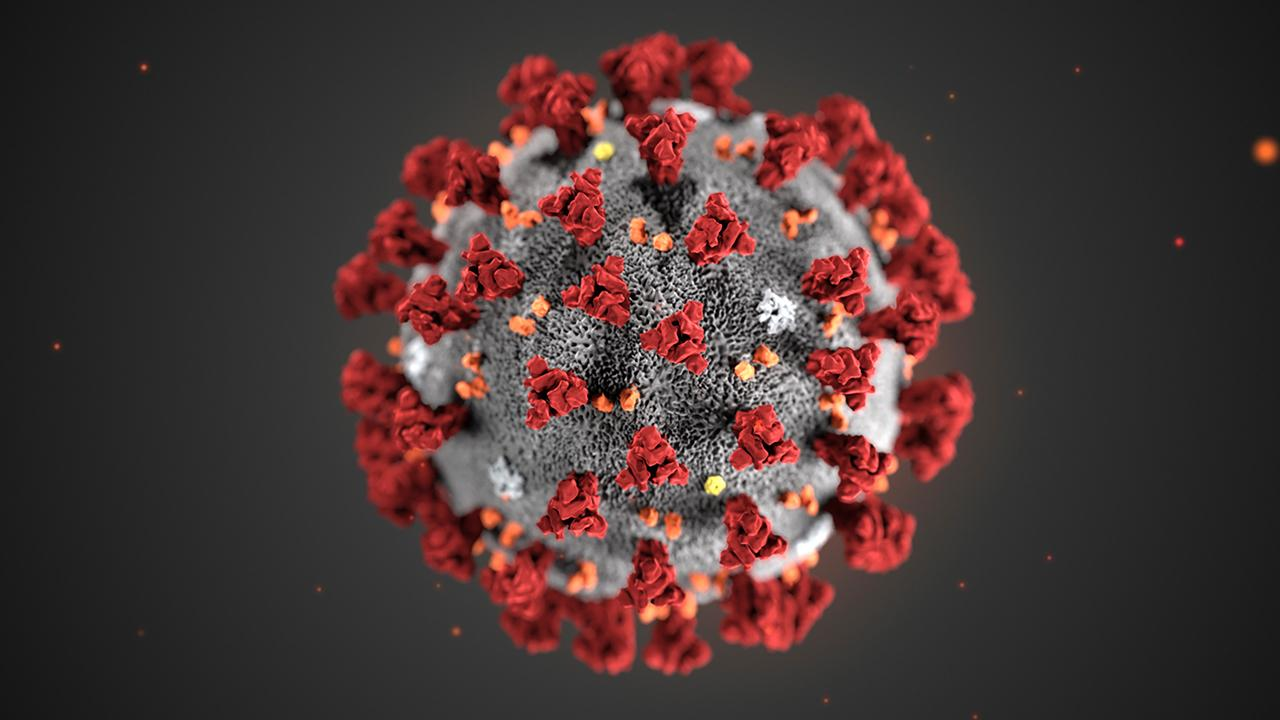

In [0]:
from IPython.display import * 
Image("https://media.foxbusiness.com/BrightCove/854081161001/202003/2652/854081161001_6141155653001_6141149610001-vs.jpg")

##Collecting data

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import json
token = {"username":"abshkpskr","key":"7bf37d08aafdc81ecb2640a1960fddbc"}
with open('kaggle.json', 'w') as file:
    json.dump(token, file)

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d imdevskp/covid19-corona-virus-india-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
covid19-corona-virus-india-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
from zipfile import ZipFile
ZipFile('covid19-corona-virus-india-dataset.zip').extractall()

import os
for i in sorted(os.listdir()):
    print(i)

.config
README.md
api.ipynb
complete.csv
country.csv
covid19-corona-virus-india-dataset.zip
district_level_latest.csv
kaggle.json
nation_level_daily.csv
patients_data.csv
sample_data
state_level_latest.csv
tests_daily.csv
tests_latest_state_level.csv
web_scraping.ipynb
zones.csv


In [0]:
#libraries for data management
import numpy as np
import pandas as pd

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objs as go
import folium 

from google.colab import files
from IPython.display import *

plotly.io.renderers.default = 'colab'
# plotly.offline.init_notebook_mode(connected=True)

In [0]:
district_data = pd.read_csv('district_level_latest.csv')
state_data = pd.read_csv('state_level_latest.csv')
nation_data = pd.read_csv('nation_level_daily.csv')

patients_data = pd.read_csv('patients_data.csv')

tests_data = pd.read_csv('tests_daily.csv')
state_tests_data = pd.read_csv('tests_latest_state_level.csv')

zones = pd.read_csv('zones.csv')

In [0]:
data = pd.read_csv('complete.csv')
data = data.drop(['Total Confirmed cases (Indian National)','Total Confirmed cases ( Foreign National )'],axis = 1)
data.columns = ['date','state','recovered','lat','long','deaths','confirmed']
data = data[['lat','long','state','date','confirmed','deaths','recovered']]

data.loc[(data['state'] == 'Union Territory of Ladakh'),'state'] = 'Ladakh'
data.loc[(data['state'] == 'Union Territory of Jammu and Kashmir'),'state'] = 'Jammu and Kashmir'
data.loc[(data['state'] == 'Telengana'),'state'] = 'Telangana'
data.loc[(data['state'] == 'Odisha'),'state'] = 'Orissa'
data.loc[(data['state'] == 'Union Territory of Chandigarh'),'state'] = 'Chandigarh'

In [0]:
bing_data = pd.read_csv('https://raw.githubusercontent.com/microsoft/Bing-COVID-19-Data/master/data/Bing-COVID19-Data.csv',index_col = 'ID')
bing_data = bing_data[(bing_data['Country_Region'] == 'India')]# & (bing_data['Latitude'] != 22.49312) & (bing_data['Longitude'] != 79.72701)]
bing_data = bing_data.drop(['ISO2','ISO3','Country_Region'],axis = 1)
bing_data.columns = ['date','confirmed','new_confirmed','deaths','new_deaths','recovered','new_recovered','lat','long','state','city']
bing_data['active'] = bing_data['confirmed'] - (bing_data['deaths'] + bing_data['recovered'])
bing_data = bing_data[(bing_data['state'] == 'Chandigarh') | 
                      (bing_data['state'] == 'Andaman and Nicobar Islands') |
                      (bing_data['city'].notna())]
# bing_data = bing_data[(bing_data['city'].isna())]
bing_data['city'] = bing_data['city'].replace(np.nan,"(Union Territory)")
bing_data = bing_data.replace(np.nan,0)

In [0]:
case_data = pd.DataFrame()

states = data['state'].unique()

for state in states:
    temp = data[(data['state'] == state)]
    temp1 = pd.DataFrame()
    temp1  = temp1.append(temp.iloc[0:1,:],ignore_index=True)
    temp1['new_confirmed'] = temp1['confirmed']
    temp1['new_deaths'] = temp1['deaths']
    temp1['new_recovered'] = temp1['recovered']
    for i in range(1,len(temp)):
        lat,lon,state,date,confirmed,death,recovered = temp.iloc[i].values
        new_confirmed = temp.iloc[i,4] - temp.iloc[i-1,4]
        new_deaths = temp.iloc[i,5] - temp.iloc[i-1,5]
        new_recovered = temp.iloc[i,6] - temp.iloc[i-1,6]
        if new_confirmed < 0:
            confirmed = temp.iloc[i-1][4]
            new_confirmed = 0
        if new_deaths < 0:
            deaths = temp.iloc[i-1][5]
            new_deaths = 0
        if new_recovered < 0:
            recovered = temp.iloc[i-1][6]
            new_recovered = 0
        temp1.loc[i] = [lat,lon,state,date,confirmed,death,recovered,new_confirmed,new_deaths,new_recovered]
    case_data = pd.concat([case_data,temp1],ignore_index=True)

#case_data

In [0]:
# case_data = bing_data[['date','state','city','confirmed','new_confirmed','deaths','new_deaths','recovered','new_recovered','lat','long']]
case_data['active'] = case_data['confirmed'] - (case_data['deaths'] + case_data['recovered'])
case_data['date'] = pd.to_datetime(case_data['date'])
case_data['confirmed']  = case_data['confirmed'].astype('int')
case_data['deaths']  = case_data['deaths'].astype('int')
case_data['recovered']  = case_data['recovered'].astype('int')
case_data['active']  = case_data['active'].astype('int')
case_data['new_confirmed']  = case_data['new_confirmed'].astype('int')
case_data['new_deaths']  = case_data['new_deaths'].astype('int')
case_data['new_recovered']  = case_data['new_recovered'].astype('int')
# case_data.loc[(case_data['state'] == ' Azerbaijan'),'state'] = 'Azerbaijan'

##Data analysis

Data analysis is done here to study the trends of spread of virus in different countries. Most of the countries has started showing fflat curve. The outcomes of virus spread mostly depends on the underlying medical conditions, reaction of public towards lockdown.

###General Analysis

In [0]:
state_case_data = case_data.groupby(['state','date']).sum().reset_index()
state_case_data = state_case_data[state_case_data['date'] == max(state_case_data['date'].values)]
state_case_data = state_case_data.drop('date',axis = 1)
state_case_data = state_case_data.set_index('state')
state_case_data = state_case_data[['confirmed','new_confirmed','deaths','new_deaths',
                                       'recovered','new_recovered','active']]
state_case_data['mortality rate'] =  (state_case_data['deaths']/state_case_data['confirmed'])*100                          
state_case_data = state_case_data.rename(columns={'confirmed':'|  confirmed  |','new_confirmed':'|  New confirmed  |',
                                                      'deaths':'|  deaths  |','new_deaths':'|  New deaths  |',
                                                      'recovered':'|  recovered  |','new_recovered':'|  New recovered  |',
                                                      'active':'|  Active  |','mortality rate':'|  Mortality Rate  |'})                          

state_case_data.sort_values('|  confirmed  |', ascending= False).style\
.background_gradient(cmap='binary',subset=["|  confirmed  |"])\
.background_gradient(cmap='Blues',subset=["|  New confirmed  |"])\
.background_gradient(cmap='binary',subset=["|  deaths  |"])\
.background_gradient(cmap='Reds',subset=["|  New deaths  |"])\
.background_gradient(cmap='binary',subset=["|  recovered  |"])\
.background_gradient(cmap='Greens',subset=["|  New recovered  |"])\
.background_gradient(cmap='Purples',subset=["|  Active  |"])\
.background_gradient(cmap='YlOrBr',subset=["|  Mortality Rate  |"])

In [0]:
national_cumulative = pd.DataFrame(case_data.groupby(['date']).sum()).reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=national_cumulative['date'],y=national_cumulative['confirmed'],mode='lines',name='confirmed',line=dict( width=4)))
fig.add_trace(go.Scatter(x=national_cumulative['date'],y=national_cumulative['deaths'],mode='lines',name='deaths',line=dict( width=4)))
fig.add_trace(go.Scatter(x=national_cumulative['date'],y=national_cumulative['recovered'],mode='lines',name='recovered',line=dict( width=4)))
fig.add_trace(go.Scatter(x=national_cumulative['date'],y=national_cumulative['active'],mode='lines',name='Active',line=dict( width=4)))
fig.update_layout(margin=dict(l=0,r=20,b=0,t=60,pad=0),
                  paper_bgcolor="white",height= 600,
                  legend=dict(x=.01,y=.98),
                  title_text = 'Number of COVID-19 cases nationwide',font_size=15,
                  xaxis_title="Date",
                  yaxis_title="Number of cases",)
fig.layout.hovermode = 'x'
fig.show()

In [0]:
national_daily_cumulative = pd.DataFrame(case_data.groupby(['date']).sum())

fig = go.Figure()
fig.add_trace(go.Scatter(x=national_daily_cumulative.index,y=national_daily_cumulative['new_confirmed'],mode='lines',name='confirmed',line=dict( width=4)))
fig.add_trace(go.Scatter(x=national_daily_cumulative.index,y=national_daily_cumulative['new_deaths'],mode='lines',name='deaths',line=dict( width=4)))
fig.add_trace(go.Scatter(x=national_daily_cumulative.index,y=national_daily_cumulative['new_recovered'],mode='lines',name='recovered',line=dict( width=4)))
fig.update_layout(margin=dict(l=0,r=20,b=0,t=60,pad=0),
                  paper_bgcolor="white",height= 600,
                  legend=dict(x=.01,y=.98),
                  title_text = 'Number of daily COVID-19 cases nationwide',font_size=15,
                  xaxis_title="Date",
                  yaxis_title="Number of new cases",)
fig.layout.hovermode = 'x'
fig.show()

###Map Visualization

In [0]:
def CreateMap(data,color,fill_color,location = [22,80],zoom = 5,dot_size = 2):
    _map = folium.Map(location=location, tiles="OpenStreetMap", zoom_start=zoom)
    for name,cases,deaths,lat,lon in data.values:
        folium.CircleMarker([lat,lon],radius=((int(np.log(cases + 1)))*dot_size),color=color,fill_color=fill_color,
                            tooltip = "<h5 style='text-align:center;font-weight: bold'>"+ name +"</h5>"+
                            "<hr style='margin:10px;'>"+
                            "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
                            "<li>confirmed: "+str(cases)+"</li>"+
                            "<li>deaths:   "+str(deaths)+"</li>"+
                            "</ul>",fill_opacity=0.7).add_to(_map)
    return _map

state_map_plot = case_data[case_data['date'] == max(case_data['date'].values)]
state_map_plot = state_map_plot[['state','confirmed','deaths','lat','long']].reset_index().drop('index',axis = 1)
CreateMap(state_map_plot,'#1C6179','#2C94B8',)


In [0]:
district_map_plot = bing_data.groupby(['state','city']).max().reset_index()[['state','city','confirmed','deaths','lat','long']]
# district_map_plot = bing_data[bing_data['date'] == max(bing_data['date'].values)]
district_map_plot['location'] = district_map_plot['city'] + ", " + district_map_plot['state']
district_map_plot = district_map_plot[['location','confirmed','deaths','lat','long']]

CreateMap(district_map_plot,'#1C6179','#2C94B8',dot_size = 1.5)

In [0]:
CreateMap(district_map_plot,'#1C6179','#2C94B8',[28.5,77.3],10,6)

In [0]:

HTML("<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/COVID-19_India_Total_Cases_Animated_Map.gif/527px-COVID-19_India_Total_Cases_Animated_Map.gif'>")

In [0]:
# timeline_plot = case_data.groupby(['state','date']).sum().reset_index().sort_values(['date'])
# timeline_plot['date'] = timeline_plot['date'].astype('str')

# fig = px.choropleth(timeline_plot, locations="state",
#                     color=np.log10(timeline_plot["confirmed"]),
#                     hover_name="state",
#                     hover_data=["confirmed",'deaths','recovered'],
#                     color_continuous_scale=px.colors.sequential.thermal_r,
#                     locationmode="IN",
#                     animation_frame='date',color_continuous_midpoint = 3)
# fig.update_layout(margin=dict(l=20,r=0,b=0,t=70,pad=0),
#                   paper_bgcolor="white",
#                   height= 700,
#                   title_text = 'Number of daily COVID-19 cases worldwide',font_size=18)
# fig.show()

###Race Map Visualization

In [0]:
case_confirmed_racemap = case_data[['state','date','confirmed']]
case_confirmed_racemap= case_confirmed_racemap.pivot(index='state',columns='date',values= 'confirmed')
case_confirmed_racemap.to_csv('country.csv')
files.download('country.csv')

In [0]:
%%HTML
<div class="flourish-embed flourish-bar-chart-race" data-src="visualisation/2554556" data-url="https://flo.uri.sh/visualisation/2554556/embed"><script src="https://public.flourish.studio/resources/embed.js"></script></div>

###Comparison between most effected states 


In [0]:
case_country = case_data.groupby(['state','date']).sum().reset_index()
countries = case_country[case_country['confirmed'] > 5000]['state'].unique()

def CreateComparisonPlot(attr,title,x_title,y_title, y_axis_type = None):
    fig = go.Figure()
    for i in countries:
        if y_axis_type == 'log' :
            one_country = case_country[(case_country['state'] == i) & (case_country[attr] > 0)][['date',attr]]
            one_country['date'] = [i for i in range(1,len(one_country)+1)]
        else:
            one_country = case_country[(case_country['state'] == i)][['date',attr]]

        fig.add_trace(go.Scatter(x=one_country['date'],
                                y=one_country[attr],mode='lines',
                                name=i,line=dict( width=4)))
        
    # fig.add_annotation(text="First case of United states",
    #                    x='2020-01-23', y=1, arrowhead=0, showarrow=True)
    fig.update_layout(margin=dict(l=0,r=20,b=0,t=60,pad=0),
                      paper_bgcolor="white",height= 600,
                      legend=dict(x=.01,y=.98,font=dict(size =12)),
                      title_text = title,font_size=15,
                      xaxis_title=x_title,
                      yaxis_title=y_title)
    if y_axis_type == 'log' : 
        fig.update_yaxes(type="log")
        fig.update_layout(legend=dict(x=.85,y=.02,font=dict(size =12)))
        
    fig.layout.hovermode = 'x'
    fig.show()

In [0]:
CreateComparisonPlot('confirmed','Number of confirmed cases for most effected states','Date','Number of cases')

In [0]:
CreateComparisonPlot('deaths','Number of deaths in most effected states','Date','Number of cases')

In [0]:
CreateComparisonPlot('recovered','Number of recovered cases in most effected states','Date','Number of cases')

In [0]:
CreateComparisonPlot('new_confirmed','Number of Daily confirmed cases in most effected states','Date','Number of cases')

In [0]:
CreateComparisonPlot('new_deaths','Number of Daily Death cases in most effected states','Date','Number of cases')

In [0]:
CreateComparisonPlot('confirmed','Number of confirmed cases for most effected countries',
                     'Day','Number of cases (log scale)','log')

In [0]:
CreateComparisonPlot('deaths','Number of confirmed cases for most effected countries',
                     'Day','Number of cases (log scale)','log')

In [0]:
CreateComparisonPlot('recovered','Number of confirmed cases for most effected countries',
                     'Day','Number of cases (log scale)','log')

###Trend of each state separate

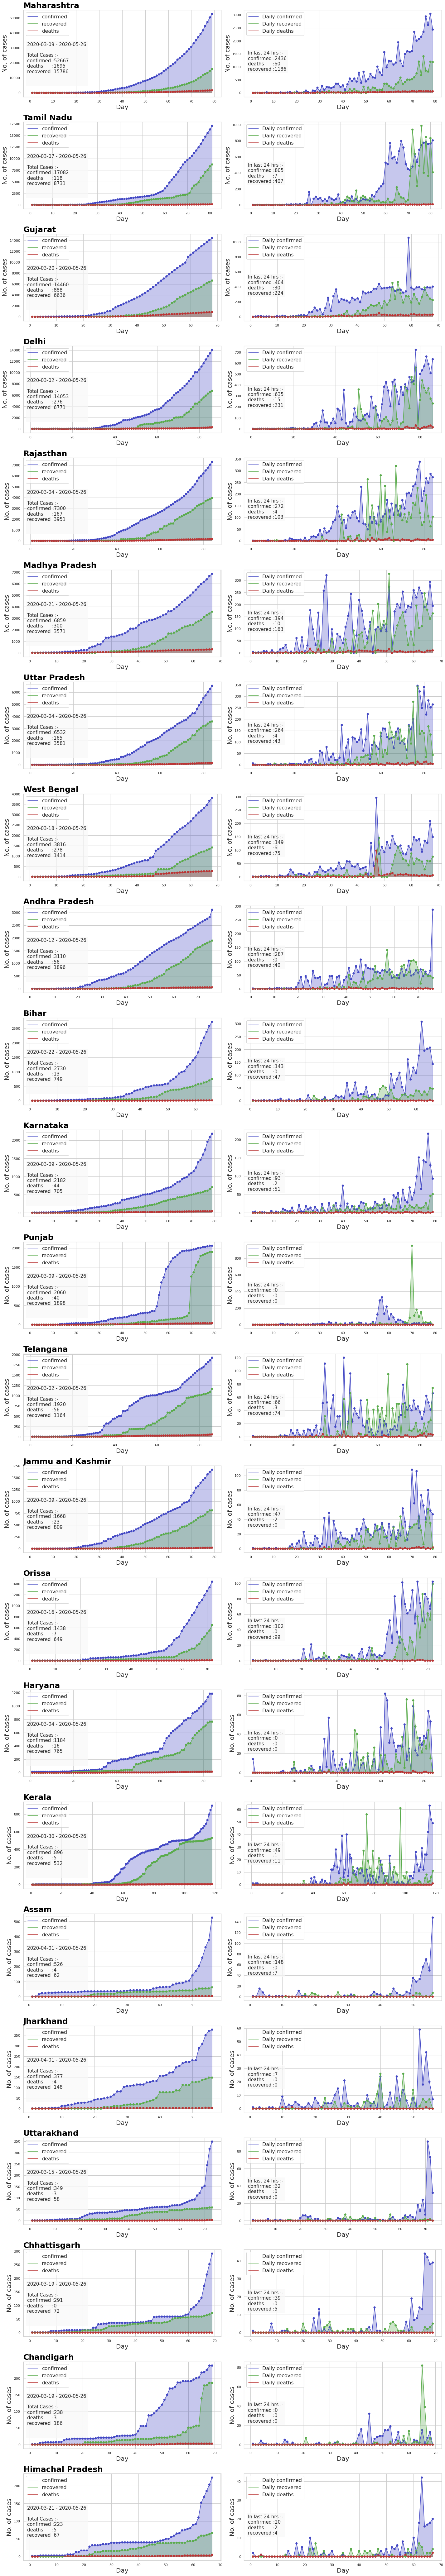

In [0]:
case_state= case_data.groupby(['state','date']).sum().reset_index()
case_state['date'] = case_state['date'].astype('str')

countries = case_state[case_state['confirmed'] > 200].sort_values(['confirmed'],ascending=False)['state'].unique()

# row = int((len(countries)+1)/3)
rows = len(countries)
columns = 2
f = plt.figure(figsize=(20,rows*5))
gs = f.add_gridspec(rows,columns)
sns.set(style = "whitegrid")

country = 0
for i in range(0,rows):
    data = case_state[case_state['state'] == countries[country]]
    data = data[data['confirmed'] > 0]
    data['day'] = [i for i in range(1,len(data)+1)]

    for j in range(0,columns):
        #if country == len(countries): break
        ax = f.add_subplot(gs[i,j])

        if j == 0:
            sns.scatterplot(data = data,x = 'day',y = 'confirmed',s = 50,color="#4348C4",edgecolor = 'none')
            sns.lineplot(data = data,x = 'day',y = 'confirmed', color = '#4348C4')
            plt.fill_between(data['day'], data['confirmed'], alpha=0.30, color = '#4348C4')

            sns.scatterplot(data = data,x = 'day',y = 'recovered',s= 50,color="#5BAC4D",edgecolor = 'none')
            sns.lineplot(data = data,x = 'day',y = 'recovered',color="#5BAC4D")
            plt.fill_between(data['day'], data['recovered'],alpha=0.30,color="#5BAC4D")

            sns.scatterplot(data = data,x = 'day',y = 'deaths',s= 50,color='#BB3535',edgecolor = 'none')
            sns.lineplot(data = data,x = 'day',y = 'deaths',color='#BB3535')
            plt.fill_between(data['day'], data['deaths'],alpha=0.30,color='#BB3535')

            ax.legend(['confirmed','recovered','deaths'], fontsize=16,loc = 'upper left')
            ax.set_xlabel('Day',fontsize=20)
            ax.set_ylabel('No. of cases',fontsize=20)
            ax.set_title(countries[country], fontdict={'fontsize': 25, 'weight' : 'bold'}, color="black",loc = 'left')
            
            text = str(data['date'].values[0]) + " - " + str(data['date'].values[-1]) + "\n" + "\n" 
            text += 'Total Cases :-' + "\n" 
            text += 'confirmed :' + str(data['confirmed'].values[-1]) + "\n" 
            text += 'deaths      :' + str(data['deaths'].values[-1]) + "\n" 
            text += 'recovered :' + str(data['recovered'].values[-1]) + "\n" + "\n" 

            ax.text(0.02, 0.15, text, fontsize=15, transform=ax.transAxes,bbox=dict(facecolor='#F8F8F8', alpha=.7))

        if j == 1:
            sns.scatterplot(data = data,x = 'day',y = 'new_confirmed',s = 50,color="#4348C4",edgecolor = 'none')
            sns.lineplot(data = data,x = 'day',y = 'new_confirmed', color = '#4348C4')
            plt.fill_between(data['day'], data['new_confirmed'], alpha=0.30, color = '#4348C4')

            sns.scatterplot(data = data,x = 'day',y = 'new_recovered',s= 50,color="#5BAC4D",edgecolor = 'none')
            sns.lineplot(data = data,x = 'day',y = 'new_recovered',color="#5BAC4D")
            plt.fill_between(data['day'], data['new_recovered'],alpha=0.30,color="#5BAC4D")

            sns.scatterplot(data = data,x = 'day',y = 'new_deaths',s= 50,color='#BB3535',edgecolor = 'none')
            sns.lineplot(data = data,x = 'day',y = 'new_deaths',color='#BB3535')
            plt.fill_between(data['day'], data['new_deaths'],alpha=0.30,color='#BB3535')
            
            ax.legend(['Daily confirmed','Daily recovered','Daily deaths'], fontsize=16,loc = 'upper left')
            ax.set_xlabel('Day',fontsize=20)
            ax.set_ylabel('No. of cases',fontsize=20)
            
            text = 'In last 24 hrs :-' + "\n" 
            text += 'confirmed :' + str(data['new_confirmed'].values[-1]) + "\n" 
            text += 'deaths      :' + str(data['new_deaths'].values[-1]) + "\n" 
            text += 'recovered :' + str(data['new_recovered'].values[-1]) 

            ax.text(0.02, 0.3, text, fontsize=15, transform=ax.transAxes,bbox=dict(facecolor='#F8F8F8', alpha=.7))

    country += 1

f.tight_layout()



###Testing Analysis

In [0]:
state_tests_data.fillna(0,inplace = True)
state_tests_data['totaltested'] = state_tests_data['totaltested'].astype('int')
state_tests_data['positive'] = state_tests_data['positive'].astype('int')
state_tests_data['testspermillion'] = state_tests_data['positive'].astype('int')
state_tests_data.loc[(state_tests_data['state'] == 'Dadra and Nagar Haveli and Daman and Diu'),'state'] = 'Dadar and Daman'

con = state_data[['state','confirmed','deaths']]
tests = state_tests_data.groupby('state').tail(1)[['state','totaltested','testspermillion']].reset_index()
tests = tests.drop('index',axis = 1)
tests = tests.merge(con,how = 'left', on = 'state')
tests.fillna(0,inplace = True)
tests['mortality rate'] =  (tests['deaths']/tests['confirmed'])*100
tests['spread rate'] = (tests['confirmed']/tests['totaltested'])*100
tests['confirmed'] = tests['confirmed'].astype('int')
tests['deaths'] = tests['deaths'].astype('int')
tests_named = tests.rename(columns={'totaltested':'|  Total Tested  |','confirmed':'|  Confirmed  |',
                                    'testspermillion':'|  Tests Per Million  |',
                                    'deaths':'|  Deaths  |','mortality rate':'|  Mortality Rate  |',
                                    'spread rate':'|  Spread Rate  |'})
tests_named = tests_named.set_index('state')
tests.fillna(0,inplace = True)

In [0]:
tests_named.sort_values('|  Total Tested  |', ascending= False).style\
.background_gradient(cmap='Blues',subset=["|  Total Tested  |"])\
.background_gradient(cmap='Greens',subset=["|  Tests Per Million  |"])\
.background_gradient(cmap='binary',subset=["|  Confirmed  |"])\
.background_gradient(cmap='Reds',subset=["|  Deaths  |"])\
.background_gradient(cmap='YlOrBr',subset=["|  Mortality Rate  |"])\
.background_gradient(cmap='Purples',subset=["|  Spread Rate  |"])

In [0]:
tests = tests.sort_values('totaltested')

fig = go.Figure()
fig.add_trace(go.Bar(y=tests['state'],x=tests['totaltested'],
                     orientation = 'h',
                     text=tests['confirmed'],name='Confirmed',marker= { 'color': 'rgb(47,138,0)'}))
fig.update_layout(margin=dict(l=0,r=20,b=0,t=60,pad=0),
                  paper_bgcolor="white",height= 800,
                  legend=dict(x=.01,y=.98),
                  title_text = 'Comparing number of tests done by states',font_size=15,
                  yaxis_title="State",
                  xaxis_title="Number of tests (in million)",)
fig.layout.hovermode = 'y'
fig.show()

In [0]:
fig = go.Figure()
fig.add_trace(go.Bar(y=tests['state'],x=tests['testspermillion'],
                     orientation='h',
                     name='confirmed',marker= { 'color': 'rgb(105,67,144)'}))
fig.update_layout(margin=dict(l=0,r=20,b=0,t=60,pad=0),
                  paper_bgcolor="white",height= 800,
                  legend=dict(x=.01,y=.98),
                  title_text = 'Number of tests per million of population in states',font_size=15,
                  yaxis_title="State",
                  xaxis_title="Number of tests per million",)
fig.layout.hovermode = 'y'
fig.show()

In [0]:
fig = go.Figure()
fig.add_trace(go.Bar(y=tests['state'],x=tests['testspermillion'],orientation = 'h',
                     name = 'Tests per million',marker= { 'color': 'rgb(105,67,144)'}))
fig.add_trace(go.Bar(y=tests['state'],x=tests['totaltested'],orientation = 'h',
                      name = 'Total Tests',marker= { 'color': 'rgb(47,138,0)'}))
fig.update_layout(margin=dict(l=0,r=20,b=0,t=60,pad=0),
                  paper_bgcolor="white",height= 800,
                  legend=dict(x=.825,y=.1),
                  title_text = 'No. of tests and No. of test per million comparison',font_size=15,
                  yaxis_title="State",
                  xaxis_title="Number of tests",
                  barmode='stack')
fig.layout.hovermode = 'y'
fig.show()

###Mortality and Spread Rates Comparison

In [0]:
global_case_data = case_data[case_data['date'] > '2020-03-25'].groupby('date').sum().reset_index()
global_case_data['Mortality Rate'] = (global_case_data['deaths']/global_case_data['confirmed'])*100

fig = go.Figure()
fig.add_trace(go.Scatter(x=global_case_data['date'],y=global_case_data['Mortality Rate'],mode='lines+markers',
                         fill='tozeroy',name = 'Total Tests',marker= { 'color': '#B87625','size' : 10},line=dict( width=4)))
fig.update_layout(margin=dict(l=0,r=20,b=0,t=60,pad=0),
                  paper_bgcolor="white",height= 600,
                  legend=dict(x=.825,y=.98),
                  title_text = 'National Mortality Rate',font_size=15,
                  xaxis_title="Date",
                  yaxis_title="Rate")
fig.layout.hovermode = 'x'
fig.show()

In [0]:
tests_mortality = tests.sort_values('mortality rate',ascending = True)

fig = go.Figure()
fig.add_trace(go.Bar(y=tests_mortality['state'],x=tests_mortality['mortality rate'],
                     orientation = 'h',
                     name = 'Total Tests',marker= { 'color': '#D38B2C'}))
fig.update_layout(margin=dict(l=0,r=20,b=0,t=60,pad=0),
                  paper_bgcolor="white",height= 600,
                  legend=dict(x=.825,y=.98),
                  title_text = 'Mortality Rate (No. of confirmed / No. of deaths)',font_size=15,
                  xaxis_title="Country",
                  yaxis_title="Rate")
fig.layout.hovermode = 'y'
fig.show()

In [0]:
tests_spread = tests.sort_values('spread rate',ascending = True).head(40)

fig = go.Figure()
fig.add_trace(go.Bar(y=tests_spread['state'],x=tests_spread['spread rate'],orientation = 'h',
                     name = 'Total Tests',marker= { 'color': '#B325B8'}))
fig.update_layout(margin=dict(l=0,r=20,b=0,t=60,pad=0),
                  paper_bgcolor="white",height= 800,
                  legend=dict(x=.825,y=.98),
                  title_text = 'Spreat Rate (No. of Tests / No. of confirmed cases)',font_size=15,
                  xaxis_title="Country",
                  yaxis_title="Rate")
fig.layout.hovermode = 'x'
fig.show()

###Age Analysis

In [0]:
def GetAgeData(data):
    for i in data.index:
        age = data.loc[data.index == i,'age_bracket']
        try:
            age = int(age)
        except:
            continue
        if age <= 10: data.loc[data.index == i,'age_bracket'] = '1-10'
        if 11 <= age <= 20: data.loc[data.index == i,'age_bracket'] = '11-20'
        if 21 <= age <= 30: data.loc[data.index == i,'age_bracket'] = '21-30'
        if 31 <= age <= 40: data.loc[data.index == i,'age_bracket'] = '31-40'
        if 41 <= age <= 50: data.loc[data.index == i,'age_bracket'] = '41-50'
        if 51 <= age <= 60: data.loc[data.index == i,'age_bracket'] = '51-60'
        if 61 <= age <= 70: data.loc[data.index == i,'age_bracket'] = '61-70'
        if age > 70: data.loc[data.index == i,'age_bracket'] = '70+'

    return data.groupby('age_bracket').size().reset_index(name = 'freq')

In [0]:
 patients_data.loc[(patients_data['age_bracket'] == '1.5'),'age_bracket'] = np.nan
 patients_data.loc[(patients_data['age_bracket'] == '0.4'),'age_bracket'] = np.nan
 patients_data.loc[(patients_data['age_bracket'] == '0.3'),'age_bracket'] = np.nan
 patients_data.loc[(patients_data['age_bracket'] == '28-35'),'age_bracket'] = '31-40'

In [0]:
age_data = GetAgeData(pd.DataFrame(patients_data['age_bracket'].values,columns= ['age_bracket']))

fig = go.Figure().add_trace(go.Pie(values=age_data['freq'],labels= age_data['age_bracket'],hole = .5,text=age_data['age_bracket']))
fig.update_layout(margin=dict(l=0,r=20,b=20,t=60,pad=0),
                  paper_bgcolor="white",height= 600,
                  legend=dict(x=.825,y=.98),
                  title_text = 'Percentage of cases recorded by age',font_size=20,
                  xaxis_title="Country",
                  yaxis_title="Rate")
fig.layout.hovermode = 'x'
fig.show()

In [0]:
age_data_deseased = GetAgeData(pd.DataFrame(patients_data[patients_data['current_status'] == 'Deceased']['age_bracket'].values,columns= ['age_bracket']))


fig = go.Figure().add_trace(go.Pie(values=age_data_deseased['freq'],labels= age_data_deseased['age_bracket'],
                                   hole = .5,text=age_data_deseased['age_bracket']))
fig.update_layout(margin=dict(l=0,r=20,b=20,t=60,pad=0),
                  paper_bgcolor="white",height= 600,
                  legend=dict(x=.825,y=.98),
                  title_text = 'Percentage of cases resulted in death by age',font_size=20,
                  xaxis_title="Country",
                  yaxis_title="Rate")
fig.layout.hovermode = 'x'
fig.show()

###Gender Analysis

In [0]:
temp = pd.DataFrame(patients_data['gender'].values,columns= ['gender'])
temp = temp.fillna('NA')
temp.loc[(temp['gender'] == 'Non-Binary'),'gender'] = np.nan
gender_data = temp.groupby('gender').size().reset_index(name = 'size')

fig = go.Figure().add_trace(go.Pie(values = gender_data['size'],labels = gender_data['gender'],
                                   hole = .5,text=gender_data['gender']))
fig.update_layout(margin=dict(l=0,r=20,b=20,t=60,pad=0),
                  paper_bgcolor="white",height= 600,
                  legend=dict(x=.825,y=.98),
                  title_text = 'Percentage of cases recorded by gender',font_size=20,
                  xaxis_title="Country",
                  yaxis_title="Rate")
fig.show()

In [0]:
temp = pd.DataFrame(patients_data[patients_data['current_status'] == 'Deceased']['gender'].values,columns= ['gender'])
temp = temp.fillna('NA')
temp.loc[(temp['gender'] == 'Non-Binary'),'gender'] = np.nan
gender_data_deseased = temp.groupby('gender').size().reset_index(name = 'size')

fig = go.Figure().add_trace(go.Pie(values=gender_data_deseased['size'],labels= gender_data_deseased['gender'],
                                   hole = .5,text=gender_data_deseased['gender']))
fig.update_layout(margin=dict(l=0,r=20,b=20,t=60,pad=0),
                  paper_bgcolor="white",height= 600,
                  legend=dict(x=.825,y=.98),
                  title_text = 'Percentage of cases resulted in death by gender',font_size=20,
                  xaxis_title="Country",
                  yaxis_title="Rate")
fig.show()

###India Suppling HCQ, Paracetamol to 108 Countries

In [0]:
HTML(''' <iframe title="[Covid-19: India is supplying HCQ, Paracetamol to 108 countries ]" aria-label="Map" id="datawrapper-chart-kqJFM" src="https://datawrapper.dwcdn.net/kqJFM/1/" scrolling="no" frameborder="0" style="width: 0; min-width: 100% !important; border: none;" height="537"></iframe><script type="text/javascript">!function(){"use strict";window.addEventListener("message",(function(a){if(void 0!==a.data["datawrapper-height"])for(var e in a.data["datawrapper-height"]){var t=document.getElementById("datawrapper-chart-"+e)||document.querySelector("iframe[src*='"+e+"']");t&&(t.style.height=a.data["datawrapper-height"][e]+"px")}}))}();
</script> ''')

###Containment Zones

In [0]:
zones[zones['zone'] == 'Red'][['district','state','zone']].style.set_properties(**{'background-color': 'white',
                                                                                   'color': 'black',
                                                                                   'border-color': 'white'})

In [0]:
zones[zones['zone'] == 'Orange'][['district','state','zone']].style.set_properties(**{'background-color': 'white',
                                                                                   'color': 'black',
                                                                                   'border-color': 'white'})

In [0]:
zones[zones['zone'] == 'Green'][['district','state','zone']].style.set_properties(**{'background-color': 'white',
                                                                                   'color': 'black',
                                                                                   'border-color': 'white'})

In [0]:
zones_data = zones[['state','zone','district']]
zones_data = zones_data.dropna()
fig = px.treemap(zones_data, path=['state','zone','district'], color='zone',
                 color_discrete_map={'(?)':'#6A6E68','Green':'#00FF00', 'Red':'#E12828', 'Orange':'#C96800'},
                 hover_data=['zone'])
fig.update_layout(margin=dict(l=0,r=0,b=0,t=0,pad=0),
                  paper_bgcolor="white",height= 600,
                  legend=dict(x=.825,y=.98),
                  font_size=20)
fig.show()

###Prediction

Logistic curve is used to predict future behavior of the total number of confirmed cases

- L (the maximum number of confirmed cases) = 250000 taken from the US example (this is from long time obsolete now)
- k (growth rate) = 0.25 approximated value from most of the countries
- x0 (the day of the inflexion) = 80 approximated 

The curve being:

#y=L/(1+e<sup>−k(x−x0)</sup>)+1

In [0]:
import scipy

def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0))) + 1

d_df = case_data.groupby('date').max().reset_index()[['date','confirmed']]

def plot_logistic_fit_data(d_df, title, p0):
    d_df = d_df.sort_values(by=['date'], ascending=True)
    d_df['x'] = np.arange(len(d_df)) + 1
    d_df['y'] = d_df['confirmed']

    x = d_df['x']
    y = d_df['y']

    c2 = scipy.optimize.curve_fit(logistic,  x,  y,  p0=p0 )
    #y = logistic(x, L, k, x0)
    popt, pcov = c2

    x = range(1,d_df.shape[0] + int(popt[2]))
    y_fit = logistic(x, *popt)
    
    p_df = pd.DataFrame()
    p_df['x'] = x
    p_df['y'] = y_fit.astype(int)

    print("Predicted L (the maximum number of confirmed cases): " + str(int(popt[0])))
    print("Predicted k (growth rate): " + str(float(popt[1])))
    print("Predicted x0 (the day of the inflexion): " + str(int(popt[2])) + "")

    x0 = int(popt[2])
    
    traceC = go.Scatter(x=d_df['x'], y=d_df['y'],name="Confirmed",marker=dict(color="Red"),
                        mode = "markers+lines",text=d_df['confirmed'],)

    traceP = go.Scatter(x=p_df['x'], y=p_df['y'],name="Predicted",marker=dict(color="blue"),
                        mode = "lines",text=p_df['y'],)

    trace_x0 = go.Scatter(x = [x0, x0], y = [0, p_df.loc[p_df['x']==x0,'y'].values[0]],
                         name = "X0 - Inflexion point",marker=dict(color="black"),
                         mode = "lines",text = "X0 - Inflexion point")

    data = [traceC, traceP, trace_x0]

    layout = dict(title = 'Cumulative Conformed cases and logistic curve projection',
          xaxis = dict(title = 'Day since first case', showticklabels=True), 
          yaxis = dict(title = 'Number of cases'),
          hovermode = 'x',plot_bgcolor='rgb(275, 270, 273)')
    
    fig = go.Figure(dict(data=data, layout=layout))
    fig.show()
    
L = 250000
k = 0.25
x0 = 100
p0 = (L, k, x0)
plot_logistic_fit_data(d_df, 'India',p0)

###Fitting an exponential curve
The parameters for the curve are:

- A - the constant multiplier for the exponential
- B - the multiplier for the exponent

The curve is thus:


#y=Ae<sup>Bx</sup>

In [0]:
import datetime
import scipy
p0 = (0,0)
def plot_exponential_fit_data(d_df, title, delta, p0):
    d_df = d_df.sort_values(by=['date'], ascending=True)
    d_df['x'] = np.arange(len(d_df)) + 1
    d_df['y'] = d_df['confirmed']

    x = d_df['x'][:-delta]
    y = d_df['y'][:-delta]

    c2 = scipy.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=p0)

    A, B = c2[0]
    print(f'(y = Ae^(Bx)) A: {A}, B: {B}')
    x = range(1,d_df.shape[0] + 1)
    y_fit = A * np.exp(B * x)
    
    traceC = go.Scatter( x=d_df['x'][:-delta], y=d_df['y'][:-delta],name="Confirmed (included for fit)",
                        marker=dict(color="Red"),mode = "markers+lines",text=d_df['confirmed'])

    traceV = go.Scatter(x=d_df['x'][-delta-1:], y=d_df['y'][-delta-1:],name="Confirmed (validation)",
                        marker=dict(color="blue"),mode = "markers+lines",text=d_df['confirmed'])
    
    traceP = go.Scatter(x=np.array(x), y=y_fit,name="Projected values (fit curve)",marker=dict(color="green"),
                        mode = "lines",text=y_fit,
    )

    data = [traceC, traceV, traceP]

    layout = dict(title = 'Cumulative Conformed cases and exponential curve projection',
          xaxis = dict(title = 'Day since first case', showticklabels=True), 
          yaxis = dict(title = 'Number of cases'),plot_bgcolor='rgb(275, 270, 273)',
          hovermode = 'x')

    fig = go.Figure(dict(data=data, layout=layout))
    fig.show()

p0 = (40, 0.2)
plot_exponential_fit_data(d_df, 'I', 7, p0)

###Extra

In [0]:
!jupyter nbconvert --to html COVID_19_INDIA.ipynb 
files.download('COVID_19_Analysis.html')